In [429]:
import numpy as np
import regex as re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [430]:
#Query for type of data "Afstemning". The query returns (per default) the first 100 matches, as well as a  the "Sagstrin" and "Sag" and filter for "vedtaget" (true)
#old query
#url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=vedtaget eq true&$inlinecount=allpages'


# Gathering all the information
### Sitching together multiple queries from oda.ft
The data we are looking for is accesable via oda.ft, but can not be reached via a single query. The data is organized after a data structure described here, https://oda.ft.dk/Home/OdaModel , and in order to obtain information about what the specific politicans voted for, in relation to a specific law proposal, we need to combine and match the following queries:
- Query 1: Obtain all votings (afstemninger):
    - Get all law votings that has been passed, information about the laws, including the unique ID of each individual law
- Query 2: Obtain all individual vote IDs, for a given voting
    - For a given voting, get a list of the unique numerric actor IDs that has voted for a specific law (which is tied to a politican), as well as whether the vote was yes, no or absent
- Query 3: Obtain the relation between actor IDs and politicans
    - Get the map between numeric actor ID and entity, and match this to the voting IDs of query 2

### Query 1: Obtain all votings (afstemning) 
The query returns (per default) a json with 3 keys: 'metadata', 'value' and 'nextlink'
- the 'value' key contains a list of up 100 votings, each voting is a dict with 11 keys
- the 'nextlink' key contains a link to the next 100 votings, as well as the link for the next 100 and so forth

Filtering is done by expanding the "Sagstrin" and "Sag" keys of each voting and filtering for 3 things:
- "vedtaget" = true, the voting ended in approval
-  "sagstrin id = 17" = "3rd reading" meaning that this is the final processing of the law, if passed here, the law is implemented
-  "sag id = 3" = lovforslag, meaning that this is a law proposal (could be a voting for something else, like a budget)

In [431]:
url_sager = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=typeid eq 1 and vedtaget eq true and Sagstrin/typeid eq 17 and Sagstrin/Sag/typeid eq 3&$inlinecount=allpages'

In [432]:
#This function takes dict, extracts the next link, gets the new dict and appends it to the old dict

import requests

def get_all_pages(url):

    r = requests.get(url)

    sager = r.json()
    prev = r.json()

    while 'odata.nextLink' in prev:

        r = requests.get(prev['odata.nextLink'])
        sager['value'] += r.json()['value']
        prev = r.json()

    return sager

In [433]:
sager = get_all_pages(url_sager)
sager.keys()

dict_keys(['odata.metadata', 'odata.count', 'value', 'odata.nextLink'])

In [434]:
#checking if all sager have the same keys
test = [len(sager['value'][i].keys()) for i in range(len(sager['value']))]
np.unique(test)

array([10])

In [435]:
#they don't, so we check how many sager have missing keys
#missing_keys = [i for i in range(len(sager['value'])) if len(sager['value'][i].keys()) != 10]
#issing_keys

In [436]:
#the above is only 14, so we remove those sager
#clean_sager = [sag for sag in sager['value'] if len(sag) == 10]
clean_sager = [sag for sag in sager['value']]

In [437]:
print(f'Hence we have a total of {len(clean_sager)} sager')

Hence we have a total of 3828 sager


In [438]:
clean_sager[0].keys()

dict_keys(['Sagstrin', 'id', 'nummer', 'konklusion', 'vedtaget', 'kommentar', 'mødeid', 'typeid', 'sagstrinid', 'opdateringsdato'])

In [439]:
import json
#format dict to json
#json_sager = json.dumps([clean_sager[0]])
#parsed = json.loads(json_sager)
#print(json.dumps(parsed, indent=4))

Each voting is 3 layered nested dict with the following structure:
- Top layer, voting: Information about the voting, unique ID of the voting, whether it was approved, date of approval etc. as seen below

In [440]:
clean_sager[0].keys()

dict_keys(['Sagstrin', 'id', 'nummer', 'konklusion', 'vedtaget', 'kommentar', 'mødeid', 'typeid', 'sagstrinid', 'opdateringsdato'])

- Mid layer, "sagstrin" / "case stage": Nested dict within the voting, about the specific case process, what type of process is this (voting), what date, where was it held etc.,

In [441]:
clean_sager[0]['Sagstrin'].keys()

dict_keys(['Sag', 'id', 'titel', 'dato', 'sagid', 'typeid', 'folketingstidendeurl', 'folketingstidende', 'folketingstidendesidenummer', 'statusid', 'opdateringsdato'])

- Bottom layer, 'sag' / 'case': Nested dict within 'sagstrin, information about the specific case, in this case a law, what the law is about, the law number, category and a range of other values relating to the law itself. 

In [442]:
clean_sager[0]['Sagstrin']['Sag'].keys()

dict_keys(['id', 'typeid', 'kategoriid', 'statusid', 'titel', 'titelkort', 'offentlighedskode', 'nummer', 'nummerprefix', 'nummernumerisk', 'nummerpostfix', 'resume', 'afstemningskonklusion', 'periodeid', 'afgørelsesresultatkode', 'baggrundsmateriale', 'opdateringsdato', 'statsbudgetsag', 'begrundelse', 'paragrafnummer', 'paragraf', 'afgørelsesdato', 'afgørelse', 'rådsmødedato', 'lovnummer', 'lovnummerdato', 'retsinformationsurl', 'fremsatundersagid', 'deltundersagid'])

#### Save relevant variables as dataframe
We save all the relevant fields from this query into our law dataframe

In [465]:
import pandas as pd
import numpy as np

def law_info(data):
    df = pd.DataFrame()

    df['afstemnings_id'] = [x['id'] for x in data]
    df['sagstrin_id'] = [x['sagstrinid'] for x in data]
    df['vedtaget'] = [x['vedtaget'] for x in data]
    df['dato'] = [x['opdateringsdato'] for x in data]
    df['sag_id'] = [x['Sagstrin']['Sag']['id'] for x in data]
    df['titel']= [x['Sagstrin']['Sag']['titel'] for x in data]
    df['titel_kort'] = [x['Sagstrin']['Sag']['titelkort'] for x in data]
    df['lovnummer_num'] = [x['Sagstrin']['Sag']['nummernumerisk'] for x in data]
    df['lovnummer'] = [x['Sagstrin']['Sag']['nummer'] for x in data]
    df['resume']= [x['Sagstrin']['Sag']['resume'] for x in data]
    df['periode_id']= [x['Sagstrin']['Sag']['periodeid'] for x in data]

    return df
        
#law_info = law_info(clean_sager)
#load law_info from pickle:
law_info = pd.read_pickle('law_info.pickle')

law_info.head()

,afstemnings_id,sagstrin_id,vedtaget,dato_afst_opd,dato_sagstrin,dato_sag_opd,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id,votes_adjusted,afstemnings_id_pfix
0,2,4849,True,2014-09-09T09:25:05.717,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",p2
1,4,18370,True,2018-01-25T10:25:25.64,2012-11-06T00:00:00,2018-09-27T11:27:48.387,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",p4
2,5,4849,True,2017-08-10T12:57:52.27,2014-09-09T09:15:00,2017-12-05T19:51:10.197,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",p5
3,9,4856,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:51:10.547,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,L 136 B,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",p9
4,10,2500,True,2017-08-10T12:57:52.237,2014-06-11T09:00:00,2017-12-05T19:47:57.27,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,L 172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",p10


### Query 2: Obtain individual IDs in relation to votings (aktør ID @ afstemning) 

In [444]:
#This function takes an id for a vote and collects all the votes for that vote


def get_all_votes(id):
    url = f'https://oda.ft.dk/api/Afstemning({id})/Stemme?$inlinecount=allpages'
    r = requests.get(url)
    votes = r.json()
    prev = r.json()
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        votes['value'] += r.json()['value']
        prev = r.json()
        
    return votes


votes_test = get_all_votes(clean_sager[0]['id'])

In [445]:
clean_sager[0]['id']

2

For each voting ID (a law) the function returns a list of dicts, where each dict is equavalent to a vote for that speifici law, and contains the ID of the voter (aktørid) and what was voted ("afstemningsid), along with a few other variables.

In [446]:
votes_test['value']

[{'id': 180,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 158,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 181,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 126,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 182,
  'typeid': 2,
  'afstemningid': 2,
  'aktørid': 71,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 183,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 50,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 184,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 49,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 185,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 220,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 186,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 183,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 187,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 85,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 188,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 303,
  'opdate

### Save relevant variables as a DF
Using the function we just wrote, and applying it to the list of all laws, we create a DF that contains a row for each vote defined by the unique ID of that voting, along with a dict containing all the votes for that law processing.

In [447]:
#This function takes in a df of each vote and makes a dataframe of all the votes for each vote
#### WORK IN PROGRESS ####
def votes_df(voting_df):
    df = pd.DataFrame()

    #typeid: 1=ja, 2=nej, 3=blank, 4=fraværende

    df["afstemnings_id"] = voting_df["afstemnings_id"].values
    df["votes_combined_info"] = [get_all_votes(x)['value'] for x in voting_df['afstemnings_id']] #creates a dict
    

    return df

#vote_df = votes_df(law_info)

In [448]:
#save df as pickle
#vote_df.to_pickle('vote_df.pkl')

In [449]:
#load vote_df from pickle
vote_df = pd.read_pickle('vote_df.pkl')

In [450]:
vote_df.head()

,afstemnings_id,votes_combined_info
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


### Query 3: Obtain a map between the numerical actor id (aktørid) of all politicians that has voted, and onto the actual name of the politician and the party of which they belong

In [451]:
#takes stemme-id which is id in stemme and returns info on the specific politician

#THIS DOES NOT WORK FOR ALL POLITICIANS
def get_politician(id):
    
        url = f'https://oda.ft.dk/api/Stemme({id})/Akt%C3%B8r?$expand=Parti'
        r = requests.get(url)
        print(f'OK:', id)
        
        #read r as json 
        raw =  r.json()
        
        print(f'read raw')
        politician = dict()
        politician['navn'] = raw['navn']        
        party = re.search("<party>(.*?)<\/party>", raw['biografi']).group(1)
        politician['party'] = party

        return politician



        # we are only interested in typeid: 5, which is a person

test = get_politician(1)


OK: 1
read raw


#### Create a function that returns the info of a politican, given the unique actor-id

In [452]:
import requests

def get_politician2(id):
    url = f'https://oda.ft.dk/api/Akt%C3%B8r({id})'

    # store the response of URL

    #try to open the url if fail print error
    politician = dict()
    try:
        response = requests.get(url)
        data_json = response.json()
        
        #Some politicians have a biography section where we can deduct the party, but many do not
        try:
            party = re.search("<party>(.*?)<\/party>", data_json['biografi']).group(1)
            politician['party'] = party
            politician['navn'] = data_json['fornavn'] + ' ' + data_json['efternavn']  
        except:
            try:
                #A lot of jsons are missing biografi, as well as the field "navn", but they have fornavn and efternavn
                #print('biographi not found for id:', id)
                politician['navn'] = data_json['fornavn'] + ' ' + data_json['efternavn']
                politician['party'] = 'unknown'
            except:
                print('No valid json keys for id:', id)
                politician['navn'] = 'unknown'
                politician['party'] = 'unknown'
    except:
        print('WARNING: URL not found for id:', id)
        politician['navn'] = 'invalid_url'
        politician['party'] = 'invalid_url'
        print(url)
            
    return politician



Create a DF of each unique actor ID linked to polician name and party.

In [453]:
#get the unique values of the key aktørid for each dict in the vote_df["votes_combined_info"] column
#this is a list of all the politicians that have voted
list_actor_ids = list(set([x['aktørid'] for y in vote_df["votes_combined_info"] for x in y]))

def politican_df(list_of_ids):
    df = pd.DataFrame()
    df['aktørid'] = list_of_ids
    politician_info = [get_politician2(x) for x in list_of_ids]

    df['politician_name'] = [pol['navn'] for pol in politician_info]
    df['party'] = [pol['party'] for pol in politician_info]

    return df

politican_df = politican_df(list_actor_ids)


No valid json keys for id: 5593


In [454]:
politican_df.head()

,aktørid,politician_name,party
0,5,Frank Aaen,Enhedslisten
1,12,Nicolai Wammen,Socialdemokratiet
2,13,Sara Olsvig,Inuit Ataqatigiit
3,17,Christine Antorini,Socialdemokratiet
4,18,Alex Ahrendtsen,Dansk Folkeparti


In [479]:
#import df_votes_politican from pickle to df
df_votes_politican = pd.read_pickle('df_votes_politicians_adjusted.pickle') #this is the new "vote_df", which contains the votes based on what the majority of the party voted

In [480]:
df_votes_politican

,afstemnings_id,votes_combined_info,majority_party_vote,votes_adjusted
0,2,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...","{'Socialistisk Folkeparti': 1, 'Venstre': 1, '...","[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,4,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...","{'Socialistisk Folkeparti': 1, 'Socialdemokrat...","[{'id': 850407, 'typeid': 1, 'afstemningid': 4..."
2,5,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...","{'Socialistisk Folkeparti': 1, 'Venstre': 1, '...","[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,9,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...","{'Dansk Folkeparti': 4, 'Socialistisk Folkepar...","[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,10,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...","{'Dansk Folkeparti': 1, 'Socialistisk Folkepar...","[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."
...,...,...,...,...
3757,8994,"[{'id': 2065373, 'typeid': 1, 'afstemningid': ...","{'Socialdemokratiet': 1, 'Venstre': 2, 'Danmar...","[{'id': 2065373, 'typeid': 1, 'afstemningid': ..."
3758,8997,"[{'id': 2065910, 'typeid': 2, 'afstemningid': ...","{'Uden for folketingsgrupperne': 1, 'Socialdem...","[{'id': 2065910, 'typeid': 2, 'afstemningid': ..."
3759,8998,"[{'id': 2066089, 'typeid': 2, 'afstemningid': ...","{'Uden for folketingsgrupperne': 1, 'Socialdem...","[{'id': 2066089, 'typeid': 2, 'afstemningid': ..."
3760,8999,"[{'id': 2066268, 'typeid': 2, 'afstemningid': ...","{'Uden for folketingsgrupperne': 1, 'Socialdem...","[{'id': 2066268, 'typeid': 2, 'afstemningid': ..."


In [455]:
#print the unique parties
print(set(politican_df['party']))

{'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Nye Borgerlige', 'Inuit Ataqatigiit', 'Folkaflokkurin', 'Ny Alliance', 'Socialdemokratiet', 'Moderaterne', 'Liberal Alliance', 'Siumut', 'Enhedslisten', 'Kristendemokraterne', 'Tjóðveldisflokkurin', 'Venstre', 'Uden for folketingsgrupperne', 'Frie Grønne', 'Javnaðarflokkurin', 'Nunatta Qitornai', 'Alternativet', 'Socialistisk Folkeparti', 'Danmarksdemokraterne', 'Tjóðveldi', 'Sambandsflokkurin', 'Radikale Venstre', 'unknown'}


In [456]:
#check if there are any ids where the URL was not found
print(f"Requests with failed URL? {politican_df['party'].isin(['invalid_url']).any()}")
print(f"Number of politicians where we have not managed to fetch the name {politican_df['politician_name'].value_counts()['unknown']}")
print(f"Number of politicians where we have not managed to fetch the party {politican_df['party'].value_counts()['unknown']}")

Requests with failed URL? False
Number of politicians where we have not managed to fetch the name 1
Number of politicians where we have not managed to fetch the party 46


## Splitting the votes and laws into different dataframes for each period
We merge the column of votings for each law, and as we will be matching afstemnings_id with aktør_id there is a potential conflict, because these integer values overlap (there are laws with the same ID as actors). For that reason we will add a new law_id column with a prefix. 

In [489]:
law_info['votes_combined_info'] = df_votes_politican['votes_adjusted']
#create a new column called afstemnings_id_pfix with a prefix p added to afstemnings_id
law_info['afstemnings_id_pfix'] = law_info['afstemnings_id'].apply(lambda x: 'p' + str(x))

#We assign period 24 to 23, 150 to 148, 138 to 35. These are all periods that are cut short due to elections
law_info['periode_id'] = law_info['periode_id'].apply(lambda x: 23 if x == 24 else x)
law_info['periode_id'] = law_info['periode_id'].apply(lambda x: 148 if x == 150 else x)
law_info['periode_id'] = law_info['periode_id'].apply(lambda x: 35 if x == 138 else x)

In [492]:
#We group the law_info df by period_id and extract the dato 
period_dates = law_info.groupby('periode_id')['dato_sagstrin'].apply(list).to_dict()

#We find the min and max date for each period
period_dates = {k: [min(v), max(v)] for k, v in period_dates.items()}
period_dates

{20: ['2004-11-16T00:00:00', '2004-12-17T00:00:00'],
 21: ['2005-03-17T00:00:00', '2005-06-17T00:00:00'],
 22: ['2005-11-03T00:00:00', '2006-06-02T00:00:00'],
 23: ['2006-11-21T00:00:00', '2007-10-23T00:00:00'],
 25: ['2007-12-14T00:00:00', '2008-09-09T00:00:00'],
 26: ['2008-10-10T00:00:00', '2009-06-18T00:00:00'],
 27: ['2009-11-19T00:00:00', '2010-06-16T00:00:00'],
 28: ['2010-11-18T00:00:00', '2011-07-01T00:00:00'],
 30: ['2011-11-17T00:00:00', '2012-09-13T00:00:00'],
 31: ['2012-11-06T00:00:00', '2013-06-28T09:00:00'],
 32: ['2013-11-21T10:00:00', '2014-09-09T09:15:00'],
 35: ['2014-10-31T10:00:00', '2015-08-26T13:00:00'],
 139: ['2015-11-12T10:00:00', '2016-06-03T09:00:00'],
 144: ['2016-11-24T10:00:00', '2017-06-02T10:00:00'],
 146: ['2017-11-09T00:00:00', '2018-06-04T00:00:00'],
 148: ['2018-11-15T00:00:00', '2019-09-12T00:00:00'],
 151: ['2019-10-24T00:00:00', '2020-09-29T00:00:00'],
 153: ['2020-10-22T00:00:00', '2021-08-27T00:00:00'],
 155: ['2021-10-14T00:00:00', '2022-09-2

In [493]:
#print the unique partiaes
print(set(politican_df['party']))

{'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Ny Alliance', 'Danmarksdemokraterne', 'Socialdemokratiet', 'Moderaterne', 'Venstre', 'Nye Borgerlige', 'Liberal Alliance', 'Enhedslisten', 'Other', 'Radikale Venstre', 'Alternativet', 'Socialistisk Folkeparti'}


In [477]:
#Creating a list of large parties
large_parties =['Enhedslisten', 'Ny Alliance', 'Det Konservative Folkeparti', 'Moderaterne', 'Nye Borgerlige', 'Venstre', 'Liberal Alliance', 'Alternativet', 'Socialdemokratiet', 'Danmarksdemokraterne', 'Socialistisk Folkeparti', 'Radikale Venstre', 'Dansk Folkeparti']

#If the party is not in the list of large parties, we set it to "Other"
politican_df['party'] = politican_df['party'].apply(lambda x: x if x in large_parties else 'Other')

In [494]:
#Create a color map for the parties
color_map = {}
color_map['Socialdemokratiet'] = 'firebrick'
color_map['Venstre'] = 'blue'
color_map['Dansk Folkeparti'] = 'yellow'
color_map['Enhedslisten'] = 'orange'
color_map['Nye Borgerlige'] = 'teal'
color_map['Ny Alliance'] = 'cyan'
color_map['Liberal Alliance'] = 'cyan'
color_map['Radikale Venstre'] = 'darkmagenta'
color_map['Socialistisk Folkeparti'] = 'palevioletred'
color_map['Danmarksdemokraterne'] = 'steelblue'
color_map['Alternativet'] = 'green'
color_map['Moderaterne'] = 'mediumpurple'
color_map['Det Konservative Folkeparti'] = 'yellowgreen'

#små partier og uspecificeret
color_map['Other'] = 'Grey'



In [564]:
import networkx as nx

#We first create the network directly with the unique actor IDs

def create_bipartite_graph(df):
    G = nx.Graph()
    #loop through each row of the df:
    for index, row in df.iterrows():
        #loop through each vote in the row
        #add a node with afstemnin'gs_id as name and lovnummer, titel and periode as attribute and set attribute 'type' as law
        G.add_node(row['afstemnings_id_pfix'], lovnummer=row['lovnummer_num'], title=row['titel_kort'], periode_id = row['periode_id'], type='law', bipartite=0)
        for vote in row['votes_combined_info']:
            #add edge between the law and the politician if voteid = 1 (yes)
            if vote['typeid'] == 1:
                G.add_edge(row['afstemnings_id_pfix'], vote['aktørid'], weight=1)
                #set attribute 'type' as politician
                #set node type to politician
                G.nodes[vote['aktørid']]['type'] = 'politician'
            elif vote['typeid'] == 2:
                #We add the edge with negative weight if the vote is no
                G.add_edge(row['afstemnings_id_pfix'], vote['aktørid'], weight=-3)
                #set attribute 'type' as politician
                #set node type to politician
                G.nodes[vote['aktørid']]['type'] = 'politician'
            elif vote['typeid'] == 3:
                #We add the edge with slight negative weight if the vote is blank
                G.add_edge(row['afstemnings_id_pfix'], vote['aktørid'], weight=-1)
                #set attribute 'type' as politician
                #set node type to politician
                G.nodes[vote['aktørid']]['type'] = 'politician'


                
    
    return G

G_bipartite_noattributes = create_bipartite_graph(law_info[law_info['periode_id'] == 153])

#function to loop through all politician nodes of the network and set attributes accordingly
#The function is split from the creation of the network, so that setting the attributes is not repeated for every law when politicians nodes are added
def set_politician_attributes(G):
    for node in G.nodes():
        if G.nodes[node]['type'] == 'politician':
            #set attribute 'party' as the party of the politician
            G.nodes[node]['party'] = politican_df[politican_df['aktørid'] == node]['party'].values[0]
            #set attribute 'name' as the name of the politician
            G.nodes[node]['name'] = politican_df[politican_df['aktørid'] == node]['politician_name'].values[0]
            #set attribute 'color' as the color of the party
            G.nodes[node]['color'] = color_map[G.nodes[node]['party']]
            #set node bipartite to 1
            G.nodes[node]['bipartite'] = 1
    return G

G_bipartite = set_politician_attributes(G_bipartite_noattributes)

# We do clustering on the graph
First we try out the Girvan Newmann algorithm


In [588]:
#remove the isolated nodes
G_bipartite.remove_nodes_from(list(nx.isolates(G_bipartite)))

#function from nx that splits a bipartite graph into two sets of nodes
law_nodes, politician_nodes = nx.bipartite.sets(G_bipartite)

In [593]:
#Creates a weighted unipartite graph by projecting the bipartite graph onto the politician nodes
G_uni = nx.bipartite.weighted_projected_graph(G_bipartite, politician_nodes)

In [599]:
import backbone_network as bb

In [601]:
G_uni = bb.get_graph_backbone(G_uni)


In [612]:
G_uni.edges.data(data = True)

EdgeDataView([(12, 19982, {'alpha': 0.3585, 'weight': 57}), (12, 18, {'alpha': 0.3542, 'weight': 78.50963177594494}), (12, 19475, {'alpha': 0.3558, 'weight': 78.50963177594494}), (12, 24, {'alpha': 0.354, 'weight': 78.50963177594494}), (12, 19480, {'alpha': 0.3581, 'weight': 78.50963177594494}), (12, 19996, {'alpha': 0.3577, 'weight': 8}), (12, 34, {'alpha': 0.3539, 'weight': 78.50963177594494}), (12, 38, {'alpha': 0.3543, 'weight': 78.50963177594494}), (12, 39, {'alpha': 0.3537, 'weight': 78.50963177594494}), (12, 43, {'alpha': 0.3542, 'weight': 78.50963177594494}), (12, 44, {'alpha': 0.3518, 'weight': 78.50963177594494}), (12, 48, {'alpha': 0.3539, 'weight': 78.50963177594494}), (12, 49, {'alpha': 0.354, 'weight': 78.50963177594494}), (12, 50, {'alpha': 0.3539, 'weight': 78.50963177594494}), (12, 55, {'alpha': 0.354, 'weight': 78.50963177594494}), (12, 19000, {'alpha': 0.3571, 'weight': 78.50963177594494}), (12, 59, {'alpha': 0.354, 'weight': 78.50963177594494}), (12, 67, {'alpha': 0

In [607]:
#remove the isolated nodes
G_uni.remove_nodes_from(list(nx.isolates(G_uni)))

In [556]:
#We find communities in the network based on the Girvan-Newman algorithm
#We use the function from the networkx documentation
def girvan_newman_alt(G):
    #We start by creating a copy of the graph
    G = G.copy().to_undirected()
    #We check if the graph is connected
    if nx.is_connected(G):
        #If it is, we return the original graph
        yield tuple(nx.connected_components(G))
    #If it is not connected, we find the connected components
    components = tuple(nx.connected_components(G))
    #We loop through the components
    while len(components) == 1:
        #We find the betweenness centrality of the edges
        betweenness = nx.edge_betweenness_centrality(G)
        #We find the edge with the highest betweenness centrality
        edge = max(betweenness, key=betweenness.get)
        #We remove the edge with the highest betweenness centrality
        G.remove_edge(*edge)
        #We find the connected components of the graph
        components = tuple(nx.connected_components(G))
    #We yield the connected components
    yield components

#We create a list of the communities
communities = girvan_newman_alt(test)


In [557]:
node_groups = []
for com in next(communities):
  node_groups.append(list(com))

print(node_groups)

AttributeError: 'list' object has no attribute 'to_undirected'

In [608]:
from networkx.algorithms.community.centrality import girvan_newman


In [609]:
communities2 = girvan_newman(test)

In [610]:
node_groups = []
for com in next(communities2):
  node_groups.append(list(com))

print(node_groups)

AttributeError: 'list' object has no attribute 'number_of_edges'

In [525]:
politican_df[politican_df['aktørid'] == 19996]

,aktørid,politician_name,party
483,19996,Helgi Abrahamsen,Other


In [527]:
#Find all yes, no and blank votes that an actor have cast in a given period
def find_votes_period(actor_id, period_id):
    #We create a list of all the votes that the actor has cast in the given period
    votes = []
    #We loop through all the laws in the given period
    for law in law_info[law_info['periode_id'] == period_id]['afstemnings_id_pfix']:
        #We loop through all the votes in the law and find the ones that the actor has cast
        for vote in law_info[law_info['afstemnings_id_pfix'] == law]['votes_combined_info'].values[0]:
            #If the actor has cast a vote, we add it to the list
            if vote['aktørid'] == actor_id:
                #we check what type of vote it is and add it to the list
                if vote['typeid'] == 1:
                    votes.append('yes')
                elif vote['typeid'] == 2:
                    votes.append('no')
                elif vote['typeid'] == 3:
                    votes.append('blank')
                elif vote['typeid'] == 4:
                    votes.append('absent')
    return votes

test = find_votes_period(19996, 153)
test

['yes', 'yes', 'yes', 'yes', 'blank', 'blank', 'blank', 'blank']

In [348]:
test.count('blank')

478

In [529]:
#Verifying that the network is bipartite
nx.is_bipartite(G_bipartite)

True

In [530]:
#export the network to csv
#nx.write_edgelist(G_bipartite, "G_bipartite.csv", delimiter=",")
#nx.write_gpickle(G_bipartite, "G_bipartite.gpickle", protocol=4)

### Some network stats

In [60]:
#import the network from g_partite.gpickle
#G_bipartite = nx.read_gpickle("G_bipartite.gpickle")

In [558]:
#total number of nodes in the network
print(f'The network has {len(G_bipartite.nodes())} nodes')
#this many are politicians
print(f'Of which {len([G_bipartite.nodes[node]["name"] for node in G_bipartite.nodes() if G_bipartite.nodes[node]["type"] == "politician"])} are politicians')
#number of edges
print(f'The network has {len(G_bipartite.edges())} edges, each indicating a yes vote')

The network has 452 nodes
Of which 200 are politicians
The network has 43233 edges, each indicating a yes vote


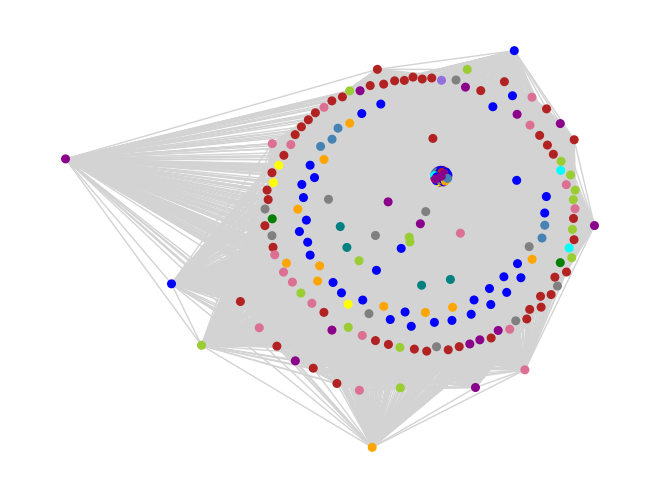

In [602]:
#draw the unipartite network with node attribute node as label using nx.draw_networkx

#node_names = nx.get_node_attributes(G_uni, 'name') 
#G_uni.remove_nodes_from(list(nx.isolates(G_uni)))
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])

In [603]:
import matplotlib.patches as patches
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

unique_parties = large_parties + ['Other']

degree_list = []
for node in G_uni.nodes():
    degree_list.append(G_uni.degree(node))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]

rgb = colors.to_rgba_array([color_map[party] for party in unique_parties])
rgb

handles_dict = {patches.Patch(color = rgb, label = party) for party, rgb in color_map.items()}


100%|██████████| 500/500 [00:01<00:00, 348.93it/s]

BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.88  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


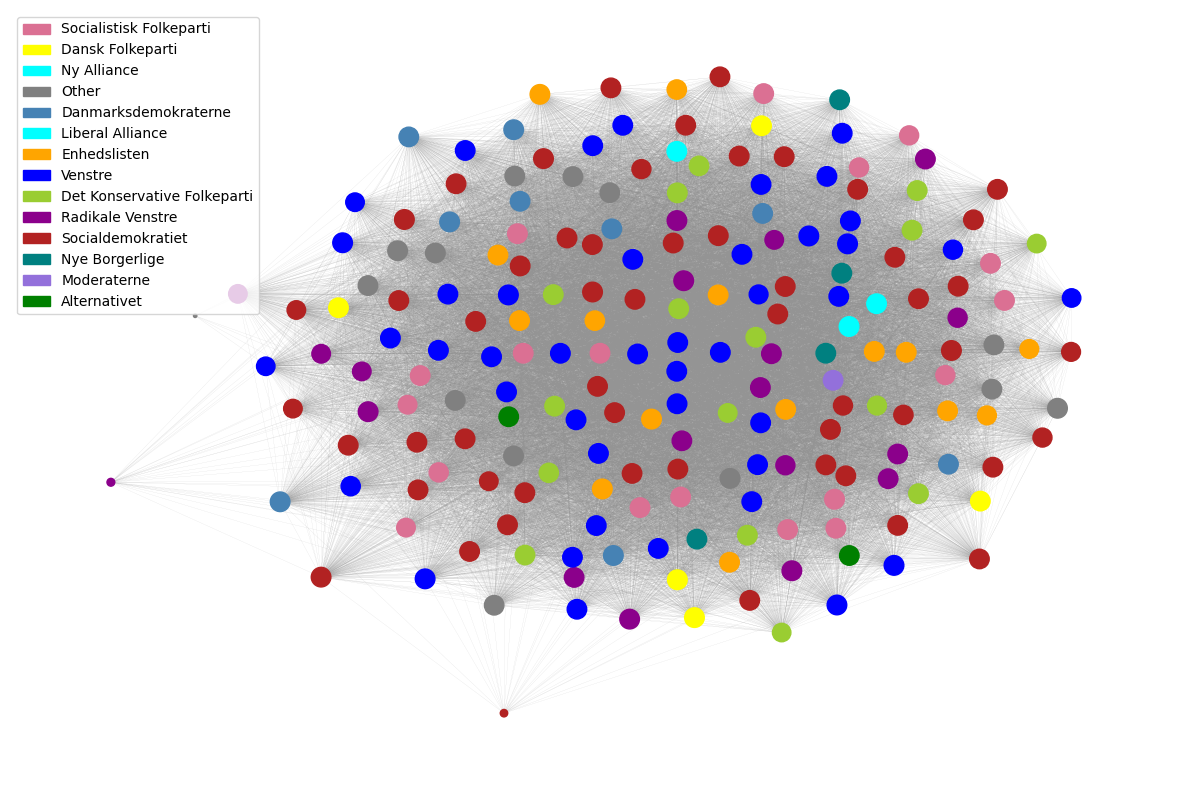

In [604]:

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0.1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    G_uni, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(G_uni, pos=positions, with_labels=False, node_size=node_size_list, node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes], labels = color_map.items(),
        width=0.05, edge_color='#949494')
ax.legend(handles = handles_dict)


# Leftover of Runes Prior work below :-)

In [233]:
#pickle dataframe
import pickle

with open('votes_df.pickle', 'wb') as f:
    pickle.dump(votes_df, f)


In [294]:
import pickle
### This is the code to load the dataframes from a pickle file file
with open('votes_df.pickle', 'rb') as handle:
    vote_info = pickle.load(handle)

In [295]:
votes_df = votes_df(df_voting)
#Takes a while to run, so we load it from a pickle file

NameError: name 'df_voting' is not defined

In [54]:
#trying to count how many voted yes in total, not currently working...
count = 0
for i in range(len(votes_df["votes_combined_info"])):
    for j in votes_df["votes_combined_info"][i][j]:
        print(j)
        if votes_df["votes_combined_info"][i][j]['typeid'] == 1:
            count += 1
    print(i)


TypeError: 'function' object is not subscriptable

In [109]:
#Get all unique aktør-id's
aktør_id = []
for i in range(len(vote_info["votes_combined_info"])): #for each vote
    for j in range(len(vote_info["votes_combined_info"][i])): #for each vote
        aktør_id.append(vote_info["votes_combined_info"][i][j]['aktørid'])
        

In [56]:
unique_politicians = np.unique(aktør_id)

In [57]:
len(unique_politicians)

615

Earliest law passed in dataset was on 2014-09-09T09:25:05.717
Latest law passed in dataset was on 2022-10-06T23:22:21.437


In [59]:
law_info.head()

,afstemnings_id,sagstrin_id,vedtaget,dato,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2,4849,True,2014-09-09T09:25:05.717,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,3,17351,True,2018-01-24T16:46:33.99,5604,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2,V 2,,31
2,4,18370,True,2018-01-25T10:25:25.64,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
3,5,4849,True,2017-08-10T12:57:52.27,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
4,6,16581,True,2017-08-10T12:57:52.257,5384,Forslag til folketingsbeslutning om dansk mili...,Om dansk militært bidrag til støtte for indsat...,122,B 122,Med folketingsbeslutningen giver Folketinget s...,32


In [60]:
vote_info["votes_combined_info"][0][0]

{'id': 180,
 'typeid': 1,
 'afstemningid': 2,
 'aktørid': 158,
 'opdateringsdato': '2014-09-09T09:25:05.717'}

In [61]:
#Find votes cast by each politician
#We first create a dataframe with all the politicians and their votes
politician_votes = pd.DataFrame(unique_politicians, columns = ['aktør_id'])
politician_votes['positive_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['negative_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['blank_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['absent'] = [0 for x in range(len(unique_politicians))]

#We go through each vote and add the votes to the dataframe
for i in range(len(vote_info["votes_combined_info"])): #for each law
    for j in range(len(vote_info["votes_combined_info"][i])): #for each vote
        aktør_id = vote_info["votes_combined_info"][i][j]['aktørid']
        vote = vote_info["votes_combined_info"][i][j]['typeid']
        if vote == 1:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'positive_votes'] += 1
        elif vote == 2:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'negative_votes'] += 1
        elif vote == 3:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'absent'] += 1
        elif vote == 4:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'blank_votes'] += 1


KeyboardInterrupt: 

In [ ]:
politician_votes

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet
...,...,...,...,...,...,...,...
610,19948,35,4,0,12,0,0
611,19982,164,12,1,30,0,0
612,19996,4,0,0,5,0,0
613,20051,46,0,0,14,0,0


In [ ]:
#Get name and party of politician
politician_votes['name'] = [0 for x in range(len(unique_politicians))]
politician_votes['party'] = [0 for x in range(len(unique_politicians))]

#DOES NOT WORK FOR ALL POLITICIANS, problem with "get_politician function"
for i in politician_votes['aktør_id']:
    try:
        politician_votes.loc[politician_votes['aktør_id'] == i, 'name'] = get_politician(i)['navn']
        politician_votes.loc[politician_votes['aktør_id'] == i, 'party'] = get_politician(i)['party']
    except:
        print(i)
        politician_votes.loc[politician_votes['aktør_id'] == i, 'name'] = "Unknown"
        politician_votes.loc[politician_votes['aktør_id'] == i, 'party'] = "Unknown"


362
363
364
365
366
367
370
371
376
378
379
384
386
645
646
647
648
649
650
651
652
653
654
655
656
657
660
661
662
663
664
665
666
667
668
669
670
671
672
675
676
677
678
679
680
725
794
801
856
918
920
951
1023
1039
1044
1047
1067
1085
1087
1090
1094
1115
1116
1121
1124
1146
1162
1172
1183
1219
1234
1249
1250
1256
1258
1269
1280
1299
1311
1319
1325
1334
1353
1357
1358
1362
1371
1375
1378
1385
1392
1393
1398
1410
1413
1414
1417
1431
1433
1440
1444
1447
1454
1455
1461
1463
1470
1471
1473
1474
1478
1484
1495
1502
1503
1504
1513
1556
1557
1558
1618
1619
1623
1636
1718
1727
1730
1731
1739
1740
1744
1745
1746
1747
1749
1751
1752
1753
1755
1757
1759
1760
1761
1767
1768
1769
1770
1771
1773
1774
1777
1778
1779
1790
1791
1792
1793
1804
1805
1811
1814
1815
1817
1818
1821
1822
1823
1824
1829
1830
1831
1833
1844
1845
1850
1879
1880
1881
1882
1883
1885
1886
1887
1891
1911
1912
1914
1916
1951
2103
2156
3042
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3092
3093
3992
3993
3994
3995
3996
3997
39

In [150]:
with(open('politician_votes.pickle', 'wb')) as f:
    pickle.dump(politician_votes, f)


In [62]:
import pickle
import pandas
with(open('politician_votes.pickle', 'rb')) as f:
    politician_votes = pickle.load(f)

In [63]:
clean_politician = politician_votes[politician_votes['name']!='Unknown']

In [64]:
clean_politician.head()

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet


In [65]:
#Finding the politicians who were absent the higheset proportion of times
clean_politician['absent_proportion'] = clean_politician['absent']/(clean_politician['positive_votes']+clean_politician['negative_votes']+clean_politician['blank_votes']+clean_politician['absent'])

C:\Users\soilsense\AppData\Local\Temp\ipykernel_21112\1188932925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_politician['absent_proportion'] = clean_politician['absent']/(clean_politician['positive_votes']+clean_politician['negative_votes']+clean_politician['blank_votes']+clean_politician['absent'])


In [66]:
most_absent = clean_politician.sort_values(by=['absent_proportion'], ascending=False)
most_absent.head(10)

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party,absent_proportion
167,262,5,0,0,3210,Jan E. Jørgensen,Venstre,0.998445
186,294,2,0,0,954,Per Stig Møller,Det Konservative Folkeparti,0.997908
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet,0.997396
178,277,1,0,0,260,Pernille Rosenkrantz-Theil,Socialdemokratiet,0.996169
159,247,59,3,0,2771,Stine Brix,Enhedslisten,0.978115
153,234,33,0,1,979,Birthe Rønn Hornbech,Venstre,0.966436
86,144,131,37,8,2586,Pernille Vigsø Bagge,Socialistisk Folkeparti,0.936278
87,145,238,66,4,4432,Magnus Heunicke,Socialdemokratiet,0.935021
5,23,103,0,0,1036,Torben Hansen,Socialdemokratiet,0.909570
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti,0.904792


In [67]:
least_absent = clean_politician.sort_values(by=['absent_proportion'], ascending=True)
least_absent[least_absent['positive_votes']+least_absent['negative_votes'] > 100].head(10)

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party,absent_proportion
190,303,956,62,9,56,Kristian Jensen,Venstre,0.051708
183,282,136,22,3,9,Fatma Øktem,Venstre,0.052941
131,202,125,0,0,9,Orla Hav,Socialdemokratiet,0.067164
23,64,2234,221,19,210,Alex Ahrendtsen,Dansk Folkeparti,0.078241
176,273,975,146,60,121,Joachim B. Olsen,Liberal Alliance,0.092934
139,212,2184,230,18,252,Henrik Sass Larsen,Socialdemokratiet,0.093890
118,188,114,1,1,13,Anita Christensen,Dansk Folkeparti,0.100775
172,268,202,2,0,26,Lone Loklindt,Radikale Venstre,0.113043
28,71,2005,209,10,303,Mette Hjermind Dencker,Dansk Folkeparti,0.119905
99,161,901,2,0,126,Doris Jakobsen,Siumut,0.122449


In [68]:
#Finding the laziest parties
clean_politician['absent_proportion'].groupby(clean_politician['party']).mean().sort_values(ascending=False)

party
Sambandsflokkurin               0.592537
Det Konservative Folkeparti     0.546151
Danmarksdemokraterne            0.512159
Socialistisk Folkeparti         0.446126
Socialdemokratiet               0.433293
Enhedslisten                    0.415800
Alternativet                    0.389730
Liberal Alliance                0.388476
Uden for folketingsgrupperne    0.371357
Venstre                         0.368646
Radikale Venstre                0.344610
Dansk Folkeparti                0.315111
Moderaterne                     0.243690
Javnaðarflokkurin               0.143965
Siumut                          0.122449
Name: absent_proportion, dtype: float64

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of votes cast or not cast by all politicians')

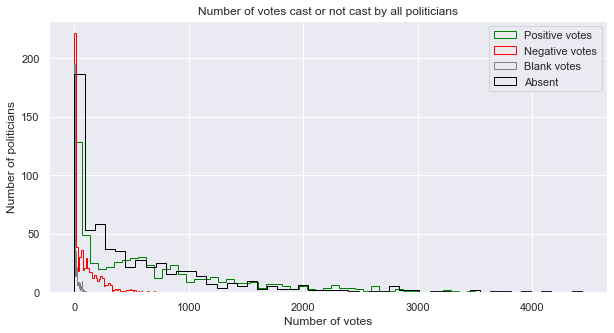

In [70]:
#Make a histogram of the number of votes cast by each politician
sns.set_theme(style="darkgrid", palette="deep", color_codes=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(politician_votes['positive_votes'], bins=50, label='Positive votes', color = "green", histtype='step')
ax.hist(politician_votes['negative_votes'], bins=50, label='Negative votes', color = "red", histtype='step')
ax.hist(politician_votes['blank_votes'], bins=50, label='Blank votes', color = "grey", histtype='step')
ax.hist(politician_votes['absent'], bins=50, label='Absent', color = "black", histtype='step')
ax.legend()
ax.set_xlabel('Number of votes')
ax.set_ylabel('Number of politicians')
ax.set_title('Number of votes cast or not cast by all politicians')

In [71]:
law_info

,afstemnings_id,sagstrin_id,vedtaget,dato,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2,4849,True,2014-09-09T09:25:05.717,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,3,17351,True,2018-01-24T16:46:33.99,5604,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2,V 2,,31
2,4,18370,True,2018-01-25T10:25:25.64,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
3,5,4849,True,2017-08-10T12:57:52.27,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
4,6,16581,True,2017-08-10T12:57:52.257,5384,Forslag til folketingsbeslutning om dansk mili...,Om dansk militært bidrag til støtte for indsat...,122,B 122,Med folketingsbeslutningen giver Folketinget s...,32
...,...,...,...,...,...,...,...,...,...,...,...
4822,8997,239747,True,2022-09-29T10:20:39.56,93164,Forslag til lov om ændring af lov om fremme af...,Om udvidelse af muligheden for at støtte initi...,211,L 211,"Lovens formål foreslås udvidet, så der bliver ...",155
4823,8998,239818,True,2022-09-29T10:20:41.39,93182,Forslag til lov om en indefrysningsordning for...,Om en indefrysningsordning for høje energiregn...,212,L 212,Forslaget etablerer en frivillig og midlertidi...,155
4824,8999,239792,True,2022-09-29T10:20:43.127,93180,Forslag til lov om likviditetslån m.v. i forbi...,Om likviditetslån til høje energiregninger.,213,L 213,"Lovforslaget tilvejebringer hjemmel til, at Er...",155
4825,9000,239805,True,2022-09-29T10:20:45.087,93181,Forslag til lov om ændring af lov om afgift af...,Om gennemførelse af Aftale om Vinterhjælp m.v.,214,L 214,Lovforslaget udmønter en række elementer af Af...,155


In [149]:
#Save to pickle file
import pickle
with(open('clean_politician.pickle', 'wb')) as f:
    pickle.dump(clean_politician, f)

#Load from pickle file
#with(open('politician_votes.pickle', 'rb')) as f:
#    politician_votes = pickle.load(f)

In [72]:
test = get_politician(politician_votes["aktør_id"][0])

In [73]:
test['party']

'Danmarksdemokraterne'

In [74]:
politician_votes

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet
...,...,...,...,...,...,...,...
610,19948,35,4,0,12,Unknown,Unknown
611,19982,164,12,1,30,Unknown,Unknown
612,19996,4,0,0,5,Unknown,Unknown
613,20051,46,0,0,14,Unknown,Unknown


In [30]:
#politician_info = [get_politician(votes_df["votes_combined_info"][0][i]['id']) for i in range(len(votes_df["votes_combined_info"][0]))]

In [35]:
#converting list to dict
#politician_dict = pd.DataFrame.from_dict(politician_info)


In [41]:
#Makes the name of the laws distinguishable from the node names of the politicians
#ubset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]

C:\Users\rune7\AppData\Local\Temp\ipykernel_17004\1692368502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]


In [102]:
len(law_info)

4827

In [103]:
subset_laws = law_info



In [104]:
#getting vote info corresponding to the subset of laws
subset_votes = vote_info[vote_info["afstemnings_id"].isin(subset_laws['afstemnings_id'].values)]

In [105]:
politician_votes.head(10)

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet
5,23,103,0,0,1036,Torben Hansen,Socialdemokratiet
6,24,2426,222,18,1192,Orla Hav,Socialdemokratiet
7,28,606,57,14,3191,Leif Lahn Jensen,Socialdemokratiet
8,33,1960,524,80,1300,Flemming Damgaard Larsen,Venstre
9,34,966,176,15,3471,Henrik Sass Larsen,Socialdemokratiet


In [110]:
#Map politician id to name and party
for i in range(len(subset_votes["votes_combined_info"])):
    print(i)
    for j in range(len(subset_votes["votes_combined_info"][i])):
        aktør_id = subset_votes["votes_combined_info"][i][j]['aktørid']
        name = politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'name'].values[0]
        party = politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'party'].values[0]
        subset_votes['votes_combined_info'][i][j]['name'] = name
        subset_votes['votes_combined_info'][i][j]['party'] = party

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [111]:
#create a color map for the parties
import random
unique_parties = []
for i in range(len(subset_votes["votes_combined_info"])):
    for j in range(len(subset_votes["votes_combined_info"][i])):
        party = subset_votes['votes_combined_info'][i][j]['party']
        if party not in unique_parties:
            unique_parties.append(party)

#Create a color map for the parties
color_map = {}
color_map['Socialdemokratiet'] = 'firebrick'
color_map['Venstre'] = 'blue'
color_map['Dansk Folkeparti'] = 'yellow'
color_map['Enhedslisten'] = 'orange'
color_map['Radikale Venstre'] = 'magenta'
color_map['Socialistisk Folkeparti'] = 'deeppink'
color_map['Alternativet'] = 'limegreen'
color_map['Moderaterne'] = 'mediumpurple'
color_map['Det Konservative Folkeparti'] = 'yellowgreen'
color_map['Uden for folketingsgrupperne'] = 'grey'
color_map['Unknown'] = 'black'
color_map['Liberal Alliance'] = 'cyan'
color_map['Javnaðarflokkurin'] = 'darkgrey'
color_map['Kristendemokraterne'] = 'darkgrey'
color_map['Siumut'] = 'darkgrey'
color_map['Danmarksdemokraterne'] = 'steelblue'
color_map['Sambandsflokkurin'] = 'darkgrey'
color = color_map[party]


In [112]:
unique_parties

['Javnaðarflokkurin',
 'Moderaterne',
 'Dansk Folkeparti',
 'Socialdemokratiet',
 'Enhedslisten',
 'Uden for folketingsgrupperne',
 'Venstre',
 'Socialistisk Folkeparti',
 'Radikale Venstre',
 'Liberal Alliance',
 'Unknown',
 'Danmarksdemokraterne',
 'Det Konservative Folkeparti',
 'Alternativet',
 'Siumut',
 'Sambandsflokkurin']

In [113]:
len(subset_laws['afstemnings_id'])

4827

In [114]:
G = nx.Graph()
G.add_nodes_from(subset_laws['afstemnings_id'],bipartite=0, color = 'grey')
for i in range(len(subset_votes)):
    for j in range(len(subset_votes["votes_combined_info"][i])):
        party = subset_votes['votes_combined_info'][i][j]['party']
        G.add_node(subset_votes["votes_combined_info"][i][j]['name'], bipartite=1, color = color_map[party], party = party)
        if subset_votes["votes_combined_info"][i][j]['typeid'] == 1:
            G.add_edge(subset_votes["afstemnings_id"][i], subset_votes["votes_combined_info"][i][j]['name'], weight = 1)

In [126]:
#edges of of the graph G
edges = G.edges()
len(edges)
#number of nodes in the graph G
len(G.nodes())

4974

In [67]:
#old one that works
# G = nx.Graph()
# G.add_nodes_from(subset_laws['afstemnings_id'],bipartite=0)
# for i in range(len(subset_votes)):
    
#     for j in range(len(subset_votes["votes_combined_info"][i])):
#         G.add_node(subset_votes["votes_combined_info"][i][j]['aktørid'], bipartite=1)
#         if subset_votes["votes_combined_info"][i][j]['typeid'] == 1:
#             G.add_edge(subset_votes["afstemnings_id"][i], subset_votes["votes_combined_info"][i][j]['aktørid'], weight = 1)

In [127]:
B = [node for node in G if node not in subset_laws['afstemnings_id'].values]

C:\Users\soilsense\AppData\Local\Temp\ipykernel_21112\893472135.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  B = [node for node in G if node not in subset_laws['afstemnings_id'].values]


In [426]:

F = nx.bipartite.weighted_projected_graph(G, B)
F.remove_nodes_from(list(nx.isolates(F)))
nx.draw(F, node_size = 5,node_color = [G.nodes[node]['color'] for node in F.nodes], with_labels = False)

KeyError: 'color'

In [129]:
degree_list = []
for node in F.nodes():
    degree_list.append(F.degree(node))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]

In [131]:
#number of edges in the graph
len(F.edges())
#nunmber of nodes in the graph


10622

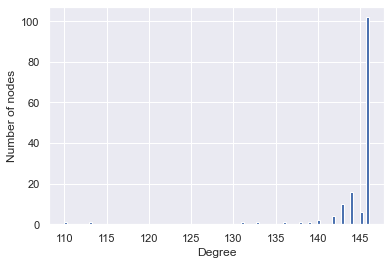

In [132]:
#plot in degree distribution of the graph F
plt.hist([F.degree(node) for node in F.nodes()], bins = 100)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()


In [98]:
#average degree distribution of the graph F
np.mean([F.degree(node) for node in F.nodes()])


134.52857142857144

In [85]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors


ModuleNotFoundError: No module named 'fa2'

In [113]:
color_map.items()

dict_items([('Socialdemokratiet', 'firebrick'), ('Venstre', 'blue'), ('Dansk Folkeparti', 'yellow'), ('Enhedslisten', 'orange'), ('Radikale Venstre', 'magenta'), ('Socialistisk Folkeparti', 'deeppink'), ('Alternativet', 'limegreen'), ('Moderaterne', 'mediumpurple'), ('Det Konservative Folkeparti', 'yellowgreen'), ('Uden for folketingsgrupperne', 'grey'), ('Unknown', 'black'), ('Liberal Alliance', 'cyan'), ('Javnaðarflokkurin', 'darkgrey'), ('Kristendemokraterne', 'darkgrey'), ('Siumut', 'darkgrey'), ('Danmarksdemokraterne', 'steelblue'), ('Sambandsflokkurin', 'darkgrey')])

In [123]:

rgb = colors.to_rgba_array([color_map[party] for party in unique_parties])
rgb

array([[0.6627451 , 0.6627451 , 0.6627451 , 1.        ],
       [0.57647059, 0.43921569, 0.85882353, 1.        ],
       [1.        , 1.        , 0.        , 1.        ],
       [0.69803922, 0.13333333, 0.13333333, 1.        ],
       [1.        , 0.64705882, 0.        , 1.        ],
       [0.50196078, 0.50196078, 0.50196078, 1.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [1.        , 0.07843137, 0.57647059, 1.        ],
       [1.        , 0.        , 1.        , 1.        ],
       [0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.2745098 , 0.50980392, 0.70588235, 1.        ],
       [0.60392157, 0.80392157, 0.19607843, 1.        ],
       [0.19607843, 0.80392157, 0.19607843, 1.        ],
       [0.6627451 , 0.6627451 , 0.6627451 , 1.        ],
       [0.6627451 , 0.6627451 , 0.6627451 , 1.        ]])

In [124]:

handles_dict = {patches.Patch(color = rgb, label = party) for party, rgb in color_map.items()}


In [111]:
import matplotlib.patches as patches



AttributeError: 'str' object has no attribute 'values'

100%|██████████| 500/500 [00:00<00:00, 1040.67it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.32  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


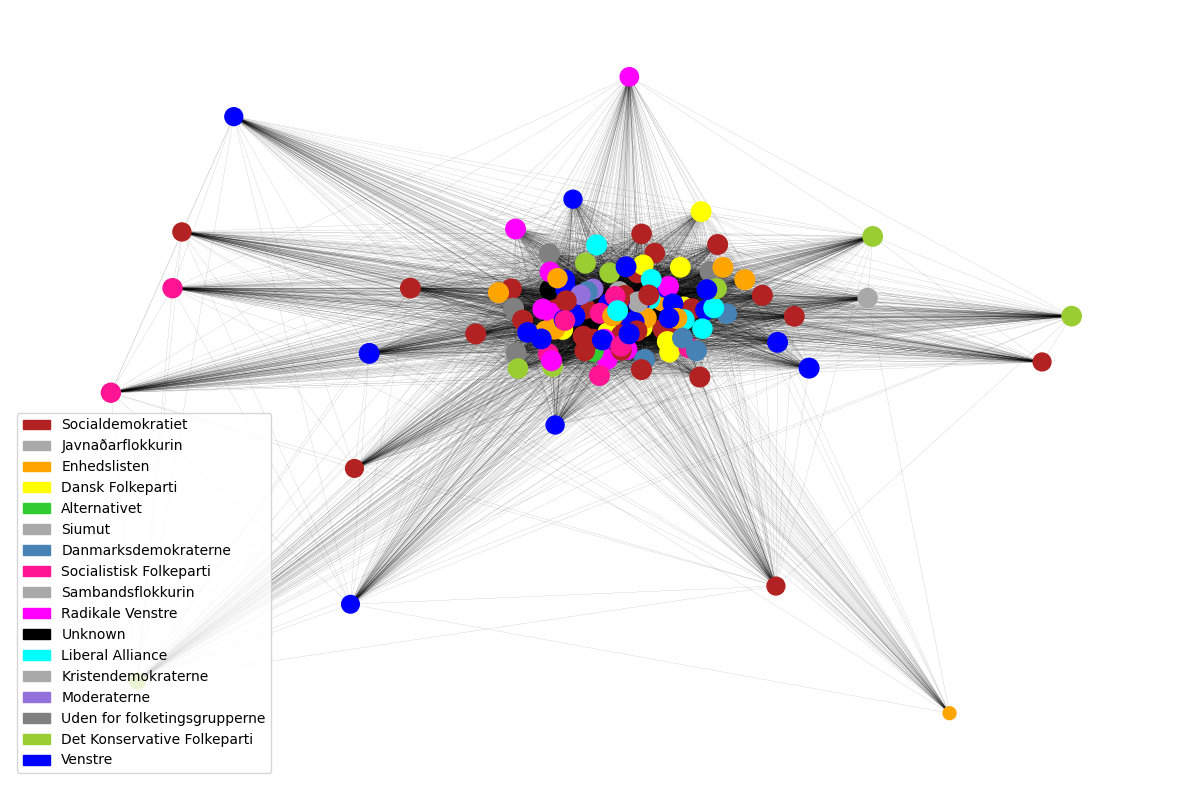

In [126]:


forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=100,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    F, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(F, pos=positions, with_labels=False, node_size=node_size_list, node_color = [G.nodes[node]['color'] for node in F.nodes], labels = color_map.items(),
        width=0.05)
ax.legend(handles = handles_dict)
